In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
np.random.seed(1)

# Generate Data

In [2]:
percentageTest = .2 # percentage of dataset to be designated as the test data

# Function to return gaussian data with given means, covariances, and number of points per class
# Returns 4 parameters: trainingData, testingData, trainingLabels, testingLabels
def generateGaussianData(mean1, mean2, cov1, cov2, pointsPerLabel):
    gauss1 = np.random.multivariate_normal(mean1, cov1, pointsPerLabel)
    labels1 = np.full((pointsPerLabel, 1), -1, dtype=np.float64)
    gauss2 = np.random.multivariate_normal(mean2, cov2, pointsPerLabel)
    labels2 = np.full((pointsPerLabel, 1), 1, dtype=np.float64)

    dataset = np.concatenate((gauss1, gauss2), axis=0)
    labels = np.concatenate((labels1, labels2), axis=0)
    
    plotRawData(dataset, labels)

    return train_test_split(dataset, labels, test_size=percentageTest, random_state=42)

In [3]:
# Function to plot the raw data
def plotRawData(dataset, labels):
    feature1 = dataset[:, 0]
    feature2 = dataset[:, 1]
    plt.scatter(feature1, feature2, c=labels[:, 0], cmap=plt.cm.coolwarm, s=20)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Raw Data")

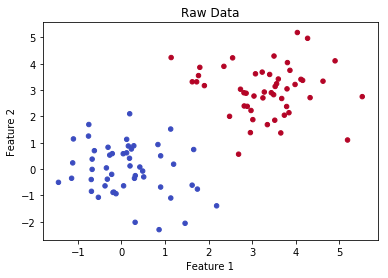

In [4]:
# Generate Gaussian data
mean1 = [0,0]
cov1 = [[1,0],[0,1]]
mean2 = [3,3]
cov2 = [[1,0],[0,1]]
dataSize = 50
trainingData, testingData, trainingLabels, testingLabels = generateGaussianData(mean1, mean2, cov1, cov2, dataSize)

# SVM
### Implementation of SVM using
- a linear kernel
- no slack variables (assumes data is linearly separable)

In [5]:
class SVMModel:
    
    def __init__(self):
        pass
    
    def train(self, trainData, trainLabels):
        self.hyperplane = CalculateHyperplane(trainData, trainLabels)
        
    def test(self, testData, testLabels):
        if self.hyperplane is None:
            raise RunTimeError('You must train the model before testing')
            
        predictions = list(map(lambda testDataPoint: SVM(self.hyperplane, testDataPoint), testData))
        accuracy = accuracy_score(testLabels.tolist(), predictions)
        return accuracy

Label calculation is done using the equation:
$$label = sign(wx +b)$$

In [32]:
# Class representing the hyperplane in SVM model
class HyperPlane:
    def __init__(self, w, b):
        self.w = w
        self.b = b
    
    def calculatePointLabel(self, x):
        return 1 if (np.dot(self.w, x) + self.b) > 0 else -1

Calcuation of the hyperplane is done by minimizing the lagrangian equation:
$$\begin{eqnarray}
\text{Minimize: } & \frac{1}{2} w \cdot w \\
\text{Subject to: } & y_i(w \cdot x_i + b) \geq 1 \\
%L_p &= \frac{1}{2}w\cdot w - \sum \alpha_i(y_i(w \cdot x_i + b) -1) \\
\end{eqnarray}
$$

These can also be represented by the dual:
$$\begin{eqnarray}
\text{Maximize: } & -\frac{1}{2} \alpha^{T}H\alpha + \sum_{i=1}^{N} \alpha_i \\\
\text{or Minimize:} & \frac{1}{2} \alpha^{T}H\alpha - \sum_{i=1}^{N} \alpha_i \\\
\text{Subject to: } & \alpha \geq 0 \\\
\text{and } & \sum_{i=1}^{N} y_i \alpha_{i} = 0 \\\
\text{where } & H_{ij} = y_i y_j x_i x_j
\end{eqnarray}$$

The API exposed for the quadratic programming library is in a slightly different form:

$$\begin{eqnarray}
\min_{x}\frac{1}{2} x^{T}Px - q^{T}x \nonumber \\\
\textrm{s.t.}\quad Gx \preceq h \\\
\textrm{and}\quad Ax = b
\end{eqnarray}
$$

To put the parameters in the correct form we must adjust the equation accordingly:

$$\begin{eqnarray}
&x = \alpha \\\ 
&P = H \\\
&q = \text{array of -1's} \\\ 
&G = \text{identity matrix of -1's (flip equality)} \\\
&h = \text{array of 0's } \\\
&A = \text{y}
\end{eqnarray}$$

I consulted http://goelhardik.github.io/2016/11/28/svm-cvxopt/ when implementing this function

In [30]:
def CalculateHyperplane(trainData, trainLabels):
    numPoints = trainData.shape[0]

    K = trainLabels * trainData
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((numPoints, 1)))
    G = matrix(-np.eye(numPoints))
    h = matrix(np.zeros(numPoints))
    A = matrix(trainLabels.T)
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    
    alphas = np.array(sol['x'])
    w = np.sum(alphas * trainLabels * trainData, axis = 0)
    supportVector = np.where(alphas > 1e-4)[0][0] # Get index of first support vector
    b = trainLabels[supportVector] - np.dot(trainData[supportVector], w)
    return HyperPlane(w, b)

In [8]:
def SVM(hyperplane, datapoint):
    label = hyperplane.calculatePointLabel(datapoint)
    return label

In [47]:
def plotDecisionBoundary(trainData, trainLabels, hyperplane):
    feature1 = trainData[:, 0]
    feature2 = trainData[:, 1]
    plt.scatter(feature1, feature2, c=trainLabels[:, 0], cmap=plt.cm.coolwarm, s=20)

    w = hyperplane.w
    b = hyperplane.b
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.arange(0, 6)
    plt.plot(x, x * slope + intercept, 'k-')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Decision Boundary")

1.0


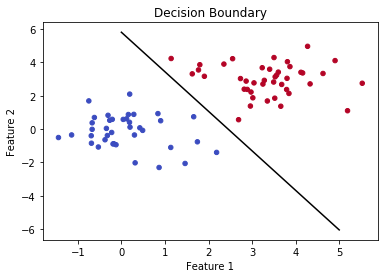

In [48]:
svmModel = SVMModel()
svmModel.train(trainingData, trainingLabels)
print(svmModel.test(testingData, testingLabels))
plotDecisionBoundary(trainingData, trainingLabels, svmModel.hyperplane)